In [56]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random
import math
import time
import copy
import pickle
import sys

In [57]:
basedir = '/Users/anamaria/git/biosens/blob_detection'
sys.path.append(basedir)
from particle import Circle
import smc

In [58]:
nice_fonts = {"text.usetex": True,
            "font.family": "serif",
            "font.serif" : "Times New Roman"}
plt.rcParams.update(nice_fonts)

plt.rc('font', family='serif', size=19)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


In [59]:
#for runnning the modified function
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running SMC


Set the attributes of the Circle object for generating a synthetic image array.

In [60]:
syntx = 4.0
synty = 6.0
syntr = 3.0
synti = 10.0

Generate the image with the above attributes.

In [61]:
#Deterministic approach
maxs = []
means = []
for i in range(100):
    syntcircle = smc.generate_particles(1, variance = 20, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
    maxs.append(np.max(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
    means.append(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
    
print(synti- np.mean(means), np.var(means),synti - np.mean(maxs),np.var(maxs))    

-0.8902320741302816 0.37428981507281484 -6.669182442537739 3.8982023213621444


In [62]:
def locate(array, val):
    q = []
    vIn = 40
    vOut = 0
    for i in range(16):
        for j in range(16):
                if array[i][j] == np.max(val):
                    q.append(100)
                elif array[i][j] in val:
                    q.append(vIn)
                else:
                    q.append(vOut)
    q = np.array(q).reshape(16,16)
    return q

In [18]:
#GPR approach
insts = []
images = []
for i in range(100):
    inst = np.random.choice(25,1)
    insts.append(inst[0])
    variance = np.random.choice(20,1)[0]
    
    syntcircle = smc.generate_particles(1, variance = variance, coord = [[syntx, synty, syntr, inst]], 
                                baseline_value=0, add_noise = True)
    images.append(np.array(syntcircle[0].image_array_noise.reshape(1,256)[0]))
    
#

In [10]:
insts = []
allc = []
images = []
f = []
for i in range(100):
    inst = np.random.choice(25,1)[0]
    x = np.random.choice(16,1)[0]
    y = np.random.choice(16,1)[0]
    r = np.random.choice(8,1)[0]
    
    f.append((inst,x,y,r))
    variance = np.random.choice(20,1)[0]
    syntcircle = smc.generate_particles(1, variance = 5, coord = [[x, y, r, inst]], 
                                baseline_value=0, add_noise = True)
    images.append(np.array(syntcircle[0].image_array_noise.reshape(1,256)[0]))
    

In [11]:
from sklearn.model_selection import train_test_split
training_data, test_data, training_data_target, test_data_target = train_test_split(images ,
                                                            f, test_size=0.33)   

## Trying different kernels

In [12]:
import GPy
k_nn = GPy.kern.MLP(256)
model_nn = GPy.models.GPRegression(np.array(training_data),
#                                       np.array(training_data_target)[:,None],
                                   np.array(training_data_target),
                                            k_nn)
print(model_nn)

model_nn.optimize()
print(model_nn)

from sklearn import metrics

accuracy = metrics.r2_score(test_data_target, model_nn.predict(np.array(test_data))[0])
mae = metrics.mean_absolute_error(test_data_target, model_nn.predict(np.array(test_data))[0])
mse = metrics.mean_squared_error(test_data_target, model_nn.predict(np.array(test_data))[0])

print(accuracy, mae, mse)


Name : GP regression
Objective : 4334.3893004099045
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  mlp.variance             |    1.0  |      +ve      |        
  mlp.weight_variance      |    1.0  |      +ve      |        
  mlp.bias_variance        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : GP regression
Objective : 798.5280133008548
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  mlp.variance             |  166.25433817748055  |      +ve      |        
  mlp.weight_variance      |  151.72987075544182  |      +ve      |        
  mlp.bias_variance        |  33404590.947783116  |      +ve      |        
  Gaussian_noise.variance  |   3.682670360238739  |      +ve      |        
0.4642698124690268 2

In [14]:
import GPy
k_rbf = GPy.kern.RBF(input_dim = 256)
model_rbf = GPy.models.GPRegression(np.array(training_data),
                                      np.array(training_data_target)[:,None],
                                            k_rbf)
print(model_rbf)

model_rbf.optimize()
print(model_rbf)

from sklearn import metrics

accuracy = metrics.r2_score(test_data_target, model_rbf.predict(np.array(test_data))[0])
mae = metrics.mean_absolute_error(test_data_target, model_rbf.predict(np.array(test_data))[0])
mse = metrics.mean_squared_error(test_data_target, model_rbf.predict(np.array(test_data))[0])

print(accuracy, mae, mse)


Name : GP regression
Objective : 6186.407220527635
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : GP regression
Objective : 979.1260996274173
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |  43.63619341944318  |      +ve      |        
  rbf.lengthscale          |                1.0  |      +ve      |        
  Gaussian_noise.variance  |  43.63619341944322  |      +ve      |        
-2.835093570974349 8.159090909090908 109.00757575757575


In [12]:
import GPy
k_m = GPy.kern.Matern32(256)
model_m = GPy.models.GPRegression(np.array(training_data),
                                      np.array(training_data_target)[:,None],
                                            k_m)
print(model_m)

model_m.optimize()
print(model_m)

from sklearn import metrics

accuracy = metrics.r2_score(test_data_target, model_m.predict(np.array(test_data))[0])
mae = metrics.mean_absolute_error(test_data_target, model_m.predict(np.array(test_data))[0])
mse = metrics.mean_squared_error(test_data_target, model_m.predict(np.array(test_data))[0])

print(accuracy, mae, mse)


Name : GP regression
Objective : 3894.7892933845956
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  Mat32.variance           |    1.0  |      +ve      |        
  Mat32.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : GP regression
Objective : 276.8729197546231
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat32.variance           |  113.73130268105587  |      +ve      |        
  Mat32.lengthscale        |  1.0000032119486943  |      +ve      |        
  Gaussian_noise.variance  |  113.73130267796668  |      +ve      |        
-2.598646811156807 11.454545353664475 181.69696626689245


Chose MLP kernel in the end, as the others give weird results sometimes.

In [16]:
model = model_nn

In [23]:
model

GP_regression.,value,constraints,priors
mlp.variance,598490.2239627186,+ve,
mlp.weight_variance,7.934655545217211e-07,+ve,
mlp.bias_variance,80958.21991750844,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


In [24]:
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis/gpmodel.pickle", "wb") as output_file:
    pickle.dump(model, output_file)

## Testing the three methods with different S:N ratios

In [78]:
syntx = 4.0
synty = 6.0
syntr = 3.0
synti = 10.0

In [90]:
#SMC approach
variance = [20, 5, 2, 0.2]
results = []
image = Circle()
image.set_characteristics(syntx, synty, syntr, synti)
image.generate_image_array(baseline_value = 0, steps_in_pixel=9, im_size=16)
da = {}
da[20] = []
da[5] = []
da[2] = []
da[0.2] = []

for i in range(100):
    
    for var in variance:
    
        image.add_noise_image(mean = 0, var = var)


        max_mean = np.mean(sorted(np.array(image.image_array_noise).reshape(256,1))[-28:-1])
        max_max = sorted(np.array(image.image_array_noise).reshape(256,1))[:-1]
        da[var].append(np.abs(max_mean-synti))


In [97]:
np.mean(da[20]), np.std(da[20])

(0.9185770743310513, 0.5852756389854852)

In [99]:
np.mean(da[5]),np.std(da[5])

(0.7150199522045905, 0.3734898964397541)

In [100]:
np.mean(da[2]),np.std(da[2])

(0.7793254000191996, 0.2705938861265734)

In [101]:
np.mean(da[0.2]),np.std(da[0.2])

(0.7805728641320908, 0.09721300001348869)

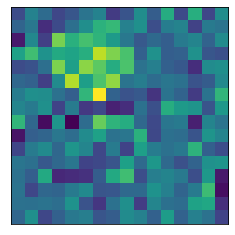

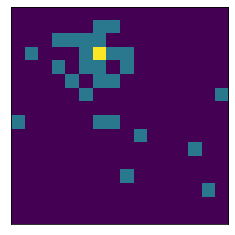

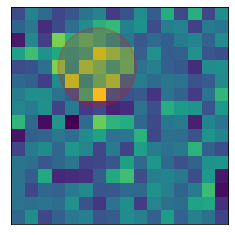

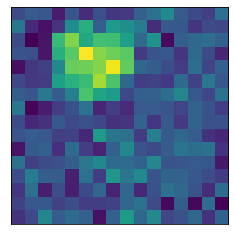

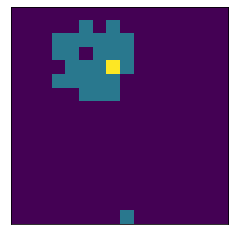

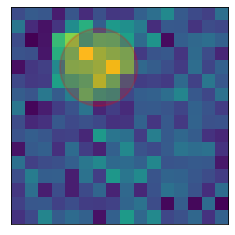

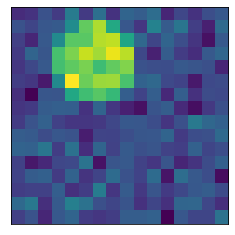

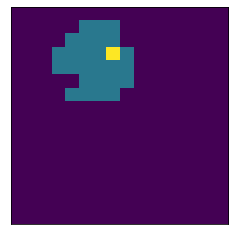

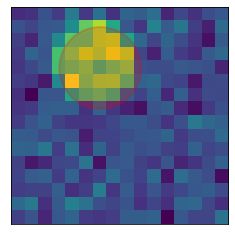

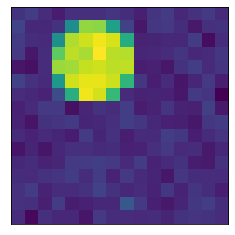

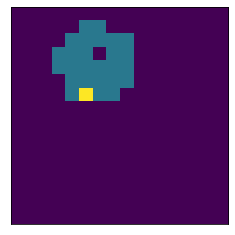

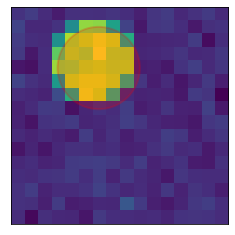

In [48]:
#SMC approach
variance = [20, 5, 2, 0.2]
results = []
image = Circle()
image.set_characteristics(syntx, synty, syntr, synti)
image.generate_image_array(baseline_value = 0, steps_in_pixel=9, im_size=16)

for var in variance:
    
    #add noise to image
    
    image.add_noise_image(mean = 0, var = var)
    
    fig, ax = plt.subplots(1,1)
    plt.imshow(image.image_array_noise)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/initial'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')

    #max method
    fig, ax = plt.subplots(1,1)
    plt.imshow(locate(image.image_array_noise, 
        sorted(np.array(image.image_array_noise).reshape(256,1))[-28:-1]))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    max_mean = np.mean(sorted(np.array(image.image_array_noise).reshape(256,1))[-28:-1])
    max_max = sorted(np.array(image.image_array_noise).reshape(256,1))[:-1]
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/max'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')
    
    #gpr method

    gpr_mean, gpr_var = model.predict(image.image_array_noise.reshape(1,256))


    #smc method
    particle_number = 500
    resampling_steps = 1000 # changed
    gaussian_variance = 10 # changed

    particle_list = smc.generate_particles(particle_number, 
                                           baseline_value = 0, random=True)
    resampled_items = []

    resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                        len(particle_list), 
                                             particle_list,
                                             image.image_array_noise, 
                                             gaussian_variance)

    smc_mean = resampled_mean[-1]
    smc_var = resampled_var[-1]
    
    ax,fig =  image.add_circles((resampled_mean[-1][1], resampled_mean[-1][0], resampled_mean[-1][2]))
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/smc'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')
    
    results.append((max_mean, max_max, gpr_mean, gpr_var, smc_mean, smc_var))


In [ ]:
syntx = 4.0
synty = 6.0
syntr = 3.0
synti = 10.0

syntx = 6.0
synty = 12.0
syntr = 4.0
synti = 10.0

syntx = 12.0
synty = 4.0
syntr = 2.0
synti = 10.0


#SMC approach
variance = [20, 5, 2, 0.2]
results = []
image = Circle()
image.set_characteristics(syntx, synty, syntr, synti)
image.generate_image_array(baseline_value = 0, steps_in_pixel=9, im_size=16)

for var in variance:
    
    #add noise to image
    
    image.add_noise_image(mean = 0, var = var)
    
    fig, ax = plt.subplots(1,1)
    plt.imshow(image.image_array_noise)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/initial'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')

    #max method
    fig, ax = plt.subplots(1,1)
    plt.imshow(locate(image.image_array_noise, 
        sorted(np.array(image.image_array_noise).reshape(256,1))[-28:-1]))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    max_mean = np.mean(sorted(np.array(image.image_array_noise).reshape(256,1))[-28:-1])
    max_max = sorted(np.array(image.image_array_noise).reshape(256,1))[:-1]
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/max'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')
    
    #gpr method

    gpr_mean, gpr_var = model.predict(image.image_array_noise.reshape(1,256))


    #smc method
    particle_number = 500
    resampling_steps = 1000 # changed
    gaussian_variance = 10 # changed

    particle_list = smc.generate_particles(particle_number, 
                                           baseline_value = 0, random=True)
    resampled_items = []

    resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                        len(particle_list), 
                                             particle_list,
                                             image.image_array_noise, 
                                             gaussian_variance)

    smc_mean = resampled_mean[-1]
    smc_var = resampled_var[-1]
    
    ax,fig =  image.add_circles((resampled_mean[-1][1], resampled_mean[-1][0], resampled_mean[-1][2]))
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/smc'+str(var)+'.png', 
                format = 'png', dpi=300, bbox_inches='tight')
    
    results.append((max_mean, max_max, gpr_mean, gpr_var, smc_mean, smc_var))


In [49]:
import pandas as pd

results_df = pd.DataFrame(results)

In [50]:
results_df

,0,1,2,3,4,5
0,11.298928,"[[-11.800429764343692], [-10.757655438863148],...",[[10.517141266303952]],[[3.0600217401515692]],"(3.93031157284871, 5.862655654524518, 2.869469...","(0.016717600237775687, 0.01609690074953555, 0...."
1,8.334950,"[[-4.954146801808595], [-4.78563073902263], [-...",[[9.107659635017626]],[[0.616909847361967]],"(3.94435287993341, 5.97619422907087, 2.8517412...","(0.02390723681158967, 0.02025496430837869, 0.0..."
2,9.050980,"[[-3.7681763345473485], [-3.73827724711824], [...",[[9.944585418357747]],[[0.2948566214181483]],"(3.9948461508806195, 6.088819158673921, 3.0100...","(0.01577983615300114, 0.017827606119708933, 0...."
3,9.247156,"[[-1.4855330069342632], [-1.1944256061170713],...",[[9.97705188515829]],[[0.029909917153418064]],"(4.000386788341061, 5.9765608353190816, 3.0290...","(0.01848334070667458, 0.019385055288515547, 0...."


In [51]:
results_df[5][0][3]

0.08842376344886653

In [52]:
results_df[4]

0    (3.93031157284871, 5.862655654524518, 2.869469...
1    (3.94435287993341, 5.97619422907087, 2.8517412...
2    (3.9948461508806195, 6.088819158673921, 3.0100...
3    (4.000386788341061, 5.9765608353190816, 3.0290...
Name: 4, dtype: object

In [53]:
results_df_final = pd.DataFrame([], columns = ['Max', 'GPmean', 'GPvar', 'SMCmean', 'SMCvar'])

In [54]:
results_df_final['Max'] = np.abs(np.subtract(results_df[0], synti))

In [55]:
results_df_final['GPmean'] = [np.abs(np.subtract(l[0][0], synti)) for l in results_df[2]]

In [56]:
results_df_final['GPvar'] = [l[0][0] for l in results_df[3]]

In [57]:
results_df_final['SMCmean'] = [np.abs(np.subtract(l[3], synti)) for l in results_df[4]]

In [58]:
results_df_final['SMCvar'] = [l[3] for l in results_df[5]]

In [59]:
results_df_final.index = ['0.5:1', '2:1', '5:1', '50:1' ]

In [60]:
results_df_final = results_df_final.reindex(index=results_df_final.index[::-1])

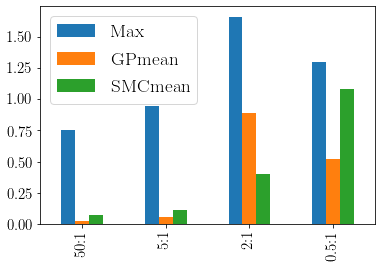

In [61]:
results_df_final.plot.bar(y = ['Max', 'GPmean', 'SMCmean'])

In [62]:
results_df_final['Maxvar'] = [0,0,0,0]

<Figure size 432x288 with 0 Axes>

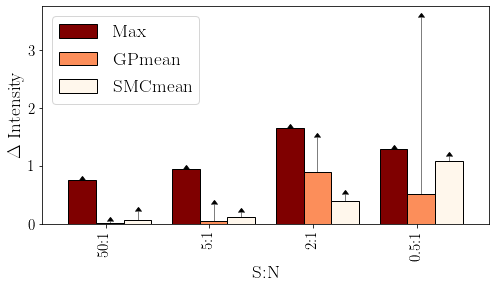

In [63]:
fig = plt.figure()


ax = results_df_final.plot(y = ['Max', 'GPmean', 'SMCmean'], kind='bar', yerr = [results_df_final['Maxvar'],
                                                                            results_df_final['GPvar'], 
                                                                            results_df_final['SMCvar']], 
        colormap='OrRd_r',edgecolor='black',grid=False,figsize=(8,4),
        position=0.45,
        error_kw=dict(ecolor='black',elinewidth=0.5, capsize = None, lolims = True),width=0.8)

plt.ylabel(r'$\Delta$ Intensity')
plt.xlabel('S:N')
plt.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis3/comparison1.png', format = 'png', dpi=300, bbox_inches='tight')

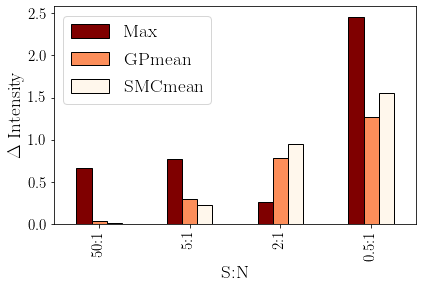

In [43]:
results_df_final.plot.bar(y = ['Max', 'GPmean', 'SMCmean'],
        colormap='OrRd_r',edgecolor='black',grid=False,figsize=(6.5,4))

plt.ylabel(r'$\Delta$ Intensity')
plt.xlabel('S:N')
plt.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis2/comparison1mean.png', format = 'png', dpi=300, bbox_inches='tight')

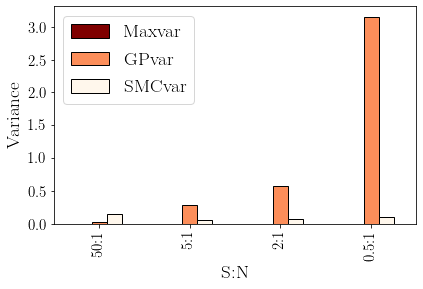

In [44]:
results_df_final.plot.bar(y = ['Maxvar', 'GPvar', 'SMCvar'],
        colormap='OrRd_r',edgecolor='black',grid=False,figsize=(6.5,4))

plt.ylabel('Variance')
plt.xlabel('S:N')
plt.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/newanalysis2/comparison1var.png', format = 'png', dpi=300, bbox_inches='tight')

In [47]:
import pandas as pd

In [52]:
mean = pd.read_csv('/Users/anamaria/Desktop/Desktop/smc_mean.csv', index_col=0)
mean.index = ['50:1','5:1','2:1','0.5:1']

In [53]:
var = pd.read_csv('/Users/anamaria/Desktop/Desktop/smc_var.csv', index_col=0)
var.index = ['50:1','5:1','2:1','0.5:1']

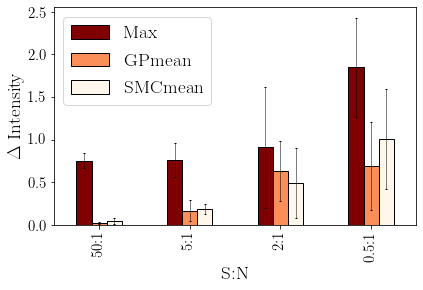

In [54]:
mean.plot.bar(y = ['Max', 'GPmean', 'SMCmean'], yerr = [ var['Max'], var['GPmean'], var['SMCmean']],
                colormap='OrRd_r',edgecolor='black',grid=False,figsize=(6.5,4),
                 error_kw=dict(ecolor='black',elinewidth=0.5, capsize = 1))

plt.ylabel(r'$\Delta$ Intensity')
plt.xlabel('S:N')

plt.savefig('/Users/anamaria/Desktop/Desktop/thesis_pictures/smc/comparisonfinalmean.pdf', 
            format = 'pdf', dpi=300, bbox_inches='tight')

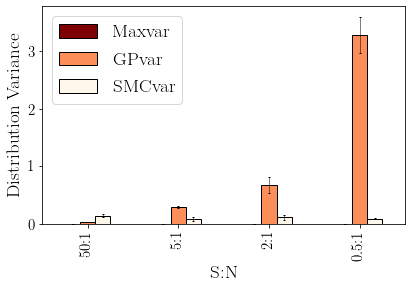

In [55]:
mean.plot.bar(y = ['Maxvar', 'GPvar', 'SMCvar'], yerr = [ var['Maxvar'], var['GPvar'], var['SMCvar']],
                colormap='OrRd_r',edgecolor='black',grid=False,figsize=(6.5,4),
                 error_kw=dict(ecolor='black',elinewidth=0.5, capsize = 1))

plt.ylabel(r'Distribution Variance')
plt.xlabel('S:N')

plt.savefig('/Users/anamaria/Desktop/Desktop/thesis_pictures/smc/comparisonfinalvar.pdf', 
            format = 'pdf', dpi=300, bbox_inches='tight')

In [64]:
results_df_final.to_csv('/Users/anamaria/Desktop/res2.csv')

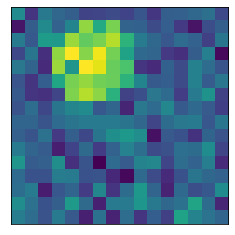

In [22]:
syntcircle = smc.generate_particles(1, variance = 5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n5i10new.png', format = 'png', dpi=400, bbox_inches='tight')

In [23]:
model.predict(syntcircle[0].image_array_noise.reshape(1,256))

(array([[10.64081583]]), array([[0.79409798]]))

9.663236263333173


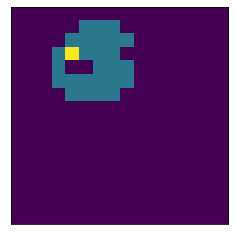

In [24]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
                  sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
print(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n5i10new_max.png', format = 'png', dpi=400, bbox_inches='tight')

In [25]:
particle_number = 500
resampling_steps = 500 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])

(4.041155263183989, 5.940623236656887, 2.9784480465083187, 10.266625429033477)


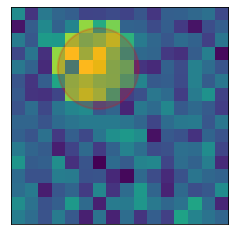

In [26]:
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/partcirc1010051251000n5i10new_smc.png', format = 'png', dpi=400, bbox_inches='tight')

In [27]:
syntx = 4.0
synty = 6.0
syntr = 3.0
synti = 25.0

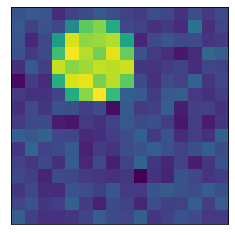

In [28]:
syntcircle = smc.generate_particles(1, variance = 5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n5i25new.png', format = 'png', dpi=400, bbox_inches='tight')

In [29]:
synti - model.predict(syntcircle[0].image_array_noise.reshape(1,256))[0]

array([[-0.17539295]])

1.9195121628080152


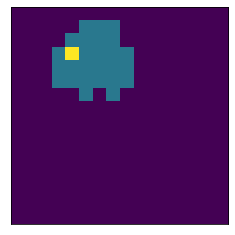

In [30]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
                  sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
print(synti - np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n5i25new_max.png', format = 'png', dpi=400, bbox_inches='tight')

In [31]:
particle_number = 500
resampling_steps = 500 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])

(4.035885410638104, 6.008381610225727, 3.016293014878446, 24.96691768892249)


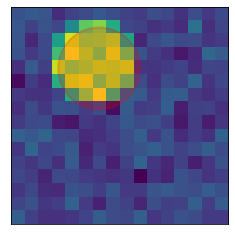

In [32]:

ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/partcirc1010051251000n5i25new_smc.png', format = 'png', dpi=400, bbox_inches='tight')

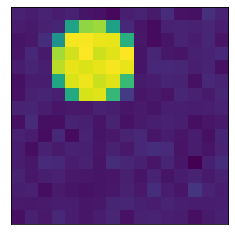

In [33]:
syntcircle = smc.generate_particles(1, variance = 0.5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n05i25new.png', format = 'png', dpi=400, bbox_inches='tight')

In [35]:
model.predict(syntcircle[0].image_array_noise.reshape(1,256))

(array([[25.11387858]]), array([[0.06914134]]))

23.13089517085165


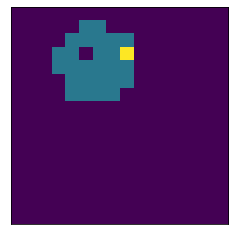

In [34]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
                  sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

print(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n05i25new_max.png', format = 'png', dpi=400, bbox_inches='tight')

In [36]:
particle_number = 500
resampling_steps = 500 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])

(3.994180289885093, 6.006685427884834, 3.0192615295333853, 24.546642722051974)


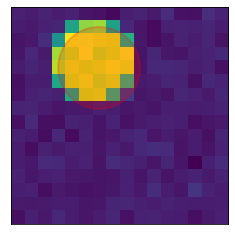

In [37]:
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/partcirc1010051251000n05i25new_smc.png', format = 'png', dpi=400, bbox_inches='tight')

In [63]:
import pandas as pd
df = pd.DataFrame([[1.869,0.114,0.449],[1.919,0.175,0.033],[0.337,0.641,0.266], 
                  [1.659, 0.849, 0.939]], 
                  columns = ['Max','GPR','SMC'],
                  index = ['50:1', '5:1', '2:1', '0.5:1'])

<Figure size 432x288 with 0 Axes>

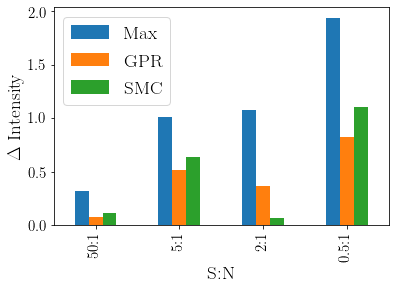

In [426]:
fig = plt.figure()
ax1 = df.plot.bar()
plt.ylabel(r'$\Delta$ Intensity')
plt.xlabel('S:N')
plt.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/comparison.png', format = 'png', dpi=400, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

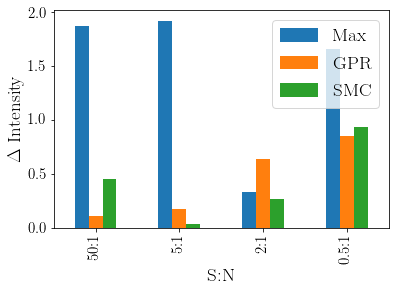

In [64]:
fig = plt.figure()
ax1 = df.plot.bar()
plt.ylabel(r'$\Delta$ Intensity')
plt.xlabel('S:N')
plt.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/comparison.png', format = 'png', dpi=400, bbox_inches='tight')

In [ ]:
Experiment 2: Test position
This time, train the GPR with all coordinates x,y,r. Or only x,y?

And for SMC
Make 4? synth gen images with different circle locations (and sizes?)

In [67]:
insts = []
allc = []
images = []
f = []
for i in range(100):
    inst = np.random.choice(25,1)[0]
    x = np.random.choice(16,1)[0]
    y = np.random.choice(16,1)[0]
    r = np.random.choice(8,1)[0]
    
    f.append((inst,x,y,r))
    variance = np.random.choice(20,1)[0]
    syntcircle = smc.generate_particles(1, variance = 5, coord = [[x, y, r, inst]], 
                                baseline_value=0, add_noise = True)
    images.append(np.array(syntcircle[0].image_array_noise.reshape(1,256)[0]))
    
      

In [70]:
from sklearn.model_selection import train_test_split
training_data, test_data, training_data_target, test_data_target = train_test_split(images ,
                                                            f, test_size=0.33)   

import GPy
k = GPy.kern.MLP(256)
model_new = GPy.models.GPRegression(np.array(training_data),
                                      np.array(training_data_target),
                                            k)
print(model_new)

model_new.optimize()
print(model_new)

from sklearn import metrics

accuracy = metrics.r2_score(test_data_target, model_new.predict(np.array(test_data))[0])
mae = metrics.mean_absolute_error(test_data_target, model_new.predict(np.array(test_data))[0])
mse = metrics.mean_squared_error(test_data_target, model_new.predict(np.array(test_data))[0])

print(accuracy, mae, mse)


Name : GP regression
Objective : 3699.478907930372
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  mlp.variance             |    1.0  |      +ve      |        
  mlp.weight_variance      |    1.0  |      +ve      |        
  mlp.bias_variance        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : GP regression
Objective : 770.5983063271392
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  mlp.variance             |  208.97770272681916  |      +ve      |        
  mlp.weight_variance      |  1.7596595862721254  |      +ve      |        
  mlp.bias_variance        |  3024057.6721276133  |      +ve      |        
  Gaussian_noise.variance  |   7.433598800780744  |      +ve      |        
0.5154554529998636 2.

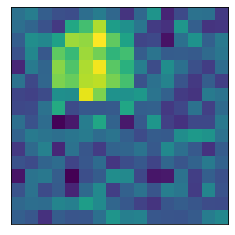

In [17]:
syntx = 4.0
synty = 6.0
syntr = 3.0
synti = 10.0

syntcircle = smc.generate_particles(1, variance = 5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate1.png', format = 'png', dpi=400, bbox_inches='tight')

In [18]:
bla = model.predict(syntcircle[0].image_array_noise.reshape(1,256))
print(bla)

(array([[9.80250232, 5.15375692, 6.24831636, 3.81498978]]), array([[20.24832385]]))


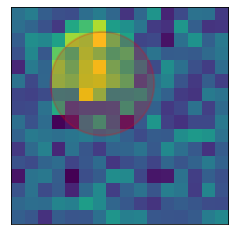

In [19]:
ax,fig =  syntcircle[0].add_circles((bla[0][0][2], 
                                     bla[0][0][1],
                                     bla[0][0][3]))
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate1_gpr.png', format = 'png', dpi=400, bbox_inches='tight')

9.448027642326432


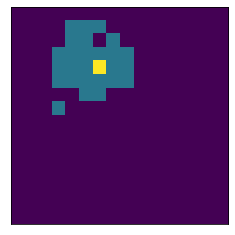

In [20]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
    sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

print(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate1_max.png', format = 'png', dpi=400, bbox_inches='tight')

(3.9696312347478906, 5.923215418996713, 3.03682472962274, 10.175411012234877)


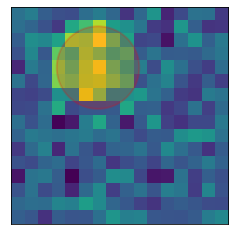

In [21]:
particle_number = 500
resampling_steps = 1000 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate1_smc.png', format = 'png', dpi=400, bbox_inches='tight')

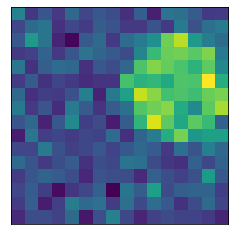

In [22]:
syntx = 6.0
synty = 12.0
syntr = 4.0
synti = 10.0


syntcircle = smc.generate_particles(1, variance = 5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate2.png', format = 'png', dpi=400, bbox_inches='tight')

In [24]:
bla = model.predict(syntcircle[0].image_array_noise.reshape(1,256))
print(bla)

(array([[10.5502113 ,  4.87556189, 12.19504756,  4.7862395 ]]), array([[21.34639985]]))


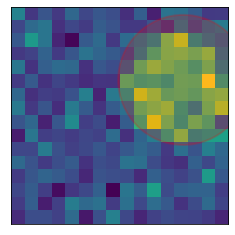

In [25]:
ax,fig =  syntcircle[0].add_circles((bla[0][0][2], 
                                     bla[0][0][1],
                                     bla[0][0][3]))
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate2_gpr.png', format = 'png', dpi=400, bbox_inches='tight')

10.932703858880373


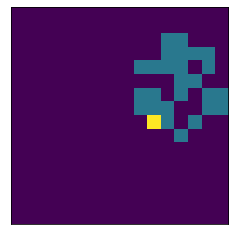

In [26]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
    sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate2_max.png', format = 'png', dpi=400, bbox_inches='tight')
print(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))

#### particle_number = 500
resampling_steps = 1000 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate2_smc.png', format = 'png', dpi=400, bbox_inches='tight')

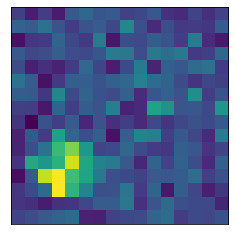

In [28]:
syntx = 12.0
synty = 4.0
syntr = 2.0
synti = 10.0
syntcircle = smc.generate_particles(1, variance = 5, coord = [[syntx, synty, syntr, synti]], 
                                baseline_value=0, add_noise = True)
fig, ax = plt.subplots(1,1)
plt.imshow(syntcircle[0].image_array_noise)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate3.png', format = 'png', dpi=400, bbox_inches='tight')

In [29]:
bla = model.predict(syntcircle[0].image_array_noise.reshape(1,256))
print(bla)

(array([[8.3202487 , 8.12672247, 6.99516387, 2.71364496]]), array([[17.97944224]]))


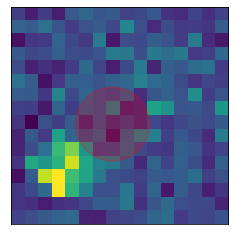

In [30]:
ax,fig =  syntcircle[0].add_circles((bla[0][0][2], 
                                     bla[0][0][1],
                                     bla[0][0][3]))
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate3_gpr.png', format = 'png', dpi=400, bbox_inches='tight')

6.758728892779815


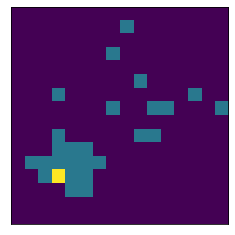

In [31]:
fig, ax = plt.subplots(1,1)
plt.imshow(locate(syntcircle[0].image_array_noise, 
    sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

print(np.mean(sorted(np.array(syntcircle[0].image_array_noise).reshape(256,1))[-28:-1]))
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate3_max.png', format = 'png', dpi=400, bbox_inches='tight')

(11.810605291477797, 3.9166871222617945, 2.173753838925495, 9.993775827474575)


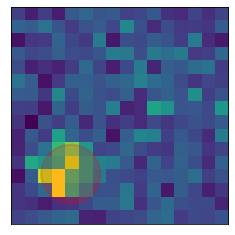

In [32]:
particle_number = 500
resampling_steps = 1000 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
print(resampled_mean[-1])
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/locate3_smc.png', format = 'png', dpi=400, bbox_inches='tight')

In [34]:
resampled_var[-1]

(0.019735303179937803,
 0.03996025540393695,
 0.017256251159696943,
 0.12224607504296944)

In [53]:
n20i10 = plt.imread('/Users/anamaria/Desktop/thesis_pictures/smc/part1010051251000n20i10.png', format='png')

TypeError: imread() got an unexpected keyword argument 'dpi'

Set the number of particles to be generated, the resampling steps and the Gaussian variance for calculating the weight of each particle.

In [12]:
particle_number = 500
resampling_steps = 1000 # changed
gaussian_variance = 10 # changed

Generate the particles.

In [40]:
start = time.time()

particle_list = smc.generate_particles(particle_number, baseline_value = 0, random=True)


end = time.time()
print(end - start)

20.758763074874878


Re-sample the particles. (It takes around 6 minutes to run it for 50 steps and 100 particles.)

In [41]:
initial_meanx, initial_meany, initial_meanr, initial_meani = smc.get_mean(particle_list)
initial_varx, initial_vary, initial_varr, initial_vari = smc.get_var(particle_list)
print(initial_meanx, initial_meany, initial_meanr, initial_meani)
print(initial_varx, initial_vary, initial_varr, initial_vari)

7.981123150387091 7.860544261112013 4.481916649702322 40.113521347013915
20.85445840558673 21.481327434123195 4.112763745041958 523.119602875496


In [42]:
particle_number = 500
resampling_steps = 500 # changed
gaussian_variance = 10 # changed

particle_list = smc.generate_particles(particle_number, 
                                       baseline_value = 0, random=True)
resampled_items = []

resampled_mean, resampled_var, 
resampled_items, weights = smc.get_resampled_particles(resampling_steps, 
                                                    len(particle_list), 
                                         particle_list,
                                         syntcircle[0].image_array_noise, 
                                         gaussian_variance)
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/'+
            'partcirc1010051251000n20i10.png',
            format = 'png', dpi=400, bbox_inches='tight')

22253.847264051437


Save the results using pickle.

In [43]:
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5i10_mean.pickle", "wb") as output_file:
    pickle.dump(resampled_mean, output_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5i10_var.pickle", "wb") as output_file:
    pickle.dump(resampled_var, output_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5i10_items.pickle", "wb") as output_file:
    pickle.dump(resampled_items, output_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5i10_weights.pickle", "wb") as output_file:
    pickle.dump(weights, output_file)
   

Or check old results saved with pickle.

In [36]:
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n20i10_mean.pickle", "rb") as input_file:
    resampled_mean = pickle.load(input_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n20i10_var.pickle", "rb") as input_file:
    resampled_var = pickle.load(input_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n20i10_items.pickle", "rb") as input_file:
    resampled_items = pickle.load(input_file)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n20i10_weights.pickle", "rb") as input_file:
    weights = pickle.load(input_file)
   
    

In [209]:
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n20i10_mean.pickle", "rb") as input_file1:
    resampled_mean_n20i10 = pickle.load(input_file1)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5i10_mean.pickle", "rb") as input_file2:
    resampled_mean_n5i10 = pickle.load(input_file2)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n5_mean.pickle", "rb") as input_file3:
    resampled_mean_n5i25 = pickle.load(input_file3)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_n0:5_mean.pickle", "rb") as input_file4:
    resamples_mean_n05i25 = pickle.load(input_file4)
with open(r"/Users/anamaria/Desktop/thesis_pictures/smc/pickles/500_1000_var.pickle", "rb") as input_file5:
    resamples_var_n005i25 = pickle.load(input_file5)


In [215]:
resamples_mean_n05i25[-1]

(3.995839586032638, 5.976313984038611, 3.004215400075699, 24.889989028817922)

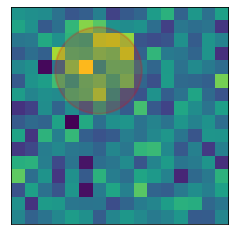

In [19]:
ax,fig =  syntcircle[0].add_circles((resampled_mean[-1][1], 
                                     resampled_mean[-1][0],
                                     resampled_mean[-1][2]))

fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/partcirc1010051251000n20i10.png', format = 'png', dpi=400, bbox_inches='tight')

# Plots 

## Mean

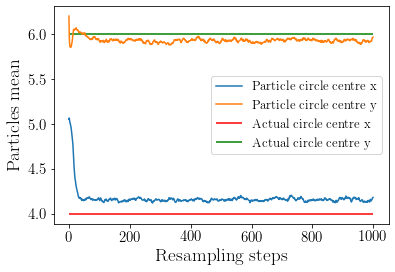

In [37]:
import pylab as plt
fig, ax = plt.subplots(1,1)
plt.plot(np.arange(resampling_steps),[y[0] for y in resampled_mean], label = 'Particle circle centre x')

plt.hlines(4,xmin = 0, xmax= resampling_steps ,color = 'red', label = 'Actual circle centre x')

plt.plot(np.arange(resampling_steps),[y[1] for y in resampled_mean], label = 'Particle circle centre y')

plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green', label = 'Actual circle centre y')

plt.xlabel('Resampling steps')
plt.ylabel('Particles mean')
plt.legend(fontsize = 13, loc = 'best')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/mean1010051251000n20xy.png', format = 'png', dpi=400, bbox_inches='tight')

#plt.ylim((0,16))

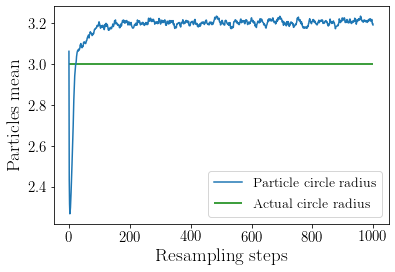

In [38]:
fig, ax = plt.subplots(1,1)
plt.plot(np.arange(resampling_steps),[y[2] for y in resampled_mean], label = 'Particle circle radius')
plt.hlines(3,xmin = 0, xmax= resampling_steps ,color = 'green', label = 'Actual circle radius')
plt.xlabel('Resampling steps')
plt.ylabel('Particles mean')
plt.legend()
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/mean1010051251000n20r.png', format = 'png', dpi=400, bbox_inches='tight')
plt.legend(fontsize = 14, loc = 'best')
#plt.ylim((0,16))

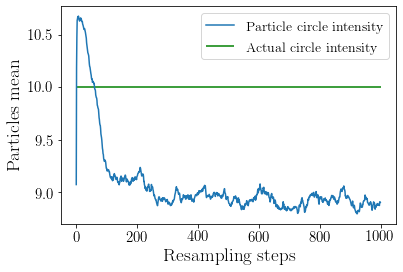

In [39]:
fig, ax = plt.subplots(1,1)
plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_mean], label = 'Particle circle intensity')
#plt.ylim((0,180))

plt.hlines(10,xmin = 0, xmax= resampling_steps ,color = 'green', label = 'Actual circle intensity')
plt.xlabel('Resampling steps')
plt.ylabel('Particles mean')
plt.legend(fontsize = 14, loc = 'best')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/mean1010051251000n20i.png', format = 'png', dpi=400, bbox_inches='tight')

## Variance

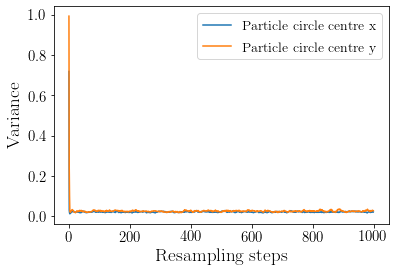

In [20]:
import pylab as plt
fig, ax = plt.subplots(1,1)
plt.plot(np.arange(resampling_steps),[y[0] for y in resampled_var], label = 'Particle circle centre x')

#plt.hlines(4,xmin = 0, xmax= resampling_steps ,color = 'red')

plt.plot(np.arange(resampling_steps),[y[1] for y in resampled_var], label = 'Particle circle centre y')

#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green')

plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var1010051251000n20i10xy.png', format = 'png', dpi=400, bbox_inches='tight')

#plt.ylim((0,16))

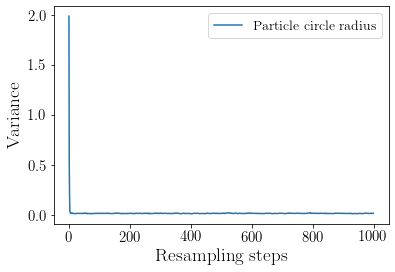

In [21]:
import pylab as plt
fig, ax = plt.subplots(1,1)

plt.plot(np.arange(resampling_steps),[y[2] for y in resampled_var], label = 'Particle circle radius')



#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green')

plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var1010051251000n20i10r.png', format = 'png', dpi=400, bbox_inches='tight')

#plt.ylim((0,16))

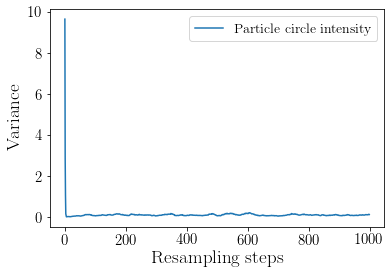

In [22]:
import pylab as plt
fig, ax = plt.subplots(1,1)

plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_var], label = 'Particle circle intensity')

#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green'
#plt.ylim(0,0.3)
plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var1010051251000n20i10i.png', format = 'png', dpi=400, bbox_inches='tight')



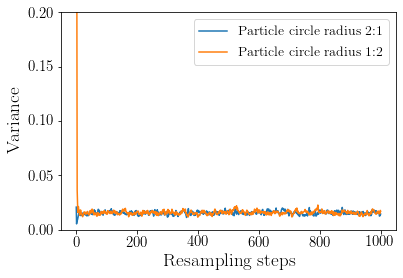

In [35]:
import pylab as plt
fig, ax = plt.subplots(1,1)


#plt.plot(np.arange(resampling_steps),[y[3] for y in resamples_var_n005i25], label = 'Particle circle intensity 500')
#plt.plot(np.arange(resampling_steps),[y[3] for y in resamples_var_n05i25], label = 'Particle circle intensity 50')
#plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_var_n5i25], label = 'Particle circle intensity 5')
plt.plot(np.arange(resampling_steps),[y[2] for y in resampled_var_n5i10], label = 'Particle circle radius 2:1')
plt.plot(np.arange(resampling_steps),[y[2] for y in resampled_var_n20i10], label = 'Particle circle radius 1:2')

#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green'
plt.ylim(0,0.2)
plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var_all.png', format = 'png', dpi=400, bbox_inches='tight')



In [ ]:
import pylab as plt
fig, ax = plt.subplots(1,1)


#plt.plot(np.arange(resampling_steps),[y[3] for y in resamples_var_n005i25], label = 'Particle circle intensity 500')
#plt.plot(np.arange(resampling_steps),[y[3] for y in resamples_var_n05i25], label = 'Particle circle intensity 50')
#plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_var_n5i25], label = 'Particle circle intensity 5')
plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_var_n5i10], label = 'Particle circle intensity 2:1')
plt.plot(np.arange(resampling_steps),[y[3] for y in resampled_var_n20i10], label = 'Particle circle intensity 1:2')

#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green'
plt.ylim(0,2)
plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var_all.png', format = 'png', dpi=400, bbox_inches='tight')



(0.0, 0.2)

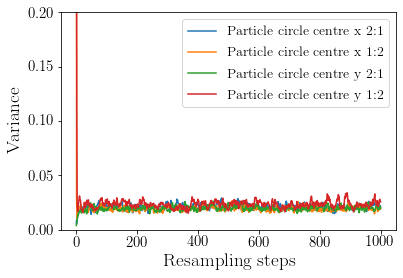

In [33]:
import pylab as plt
fig, ax = plt.subplots(1,1)
plt.plot(np.arange(resampling_steps),[y[0] for y in resampled_var_n5i10], label = 'Particle circle centre x 2:1')
plt.plot(np.arange(resampling_steps),[y[0] for y in resampled_var_n20i10], label = 'Particle circle centre x 1:2')

#plt.hlines(4,xmin = 0, xmax= resampling_steps ,color = 'red')

plt.plot(np.arange(resampling_steps),[y[1] for y in resampled_var_n5i10], label = 'Particle circle centre y 2:1')
plt.plot(np.arange(resampling_steps),[y[1] for y in resampled_var_n20i10], label = 'Particle circle centre y 1:2')

#plt.hlines(6,xmin = 0, xmax= resampling_steps ,color = 'green')

plt.xlabel('Resampling steps')
plt.ylabel('Variance')
plt.legend(fontsize = 14, loc = 'best')
#fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/var1010051251000n20i10xy.png', format = 'png', dpi=400, bbox_inches='tight')

plt.ylim((0,0.2))

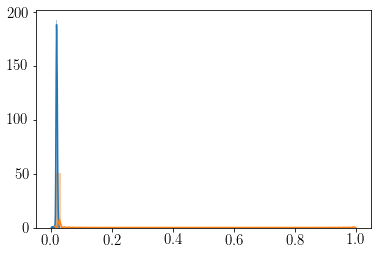

In [46]:
import seaborn as sns
sns.distplot([y[1] for y in resampled_var_n5i10])
sns.distplot([y[1] for y in resampled_var_n20i10])

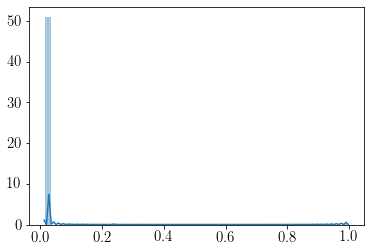

In [47]:
sns.distplot([y[1] for y in resampled_var_n20i10])

## Histograms

In [94]:
intensity_list = []
radius_list = []
x_list = []
y_list = []

for i in range(resampling_steps):
    for j in range(particle_number-1):
        intensity_list.append(resampled_items[i][j+1].intensity)
for i in range(resampling_steps):
    for j in range(particle_number-1):
        radius_list.append(resampled_items[i][j+1].radius)
for i in range(resampling_steps):
    for j in range(particle_number-1):
        x_list.append(resampled_items[i][j+1].centre_x)
for i in range(resampling_steps):
    for j in range(particle_number-1):
        y_list.append(resampled_items[i][j+1].centre_y)       

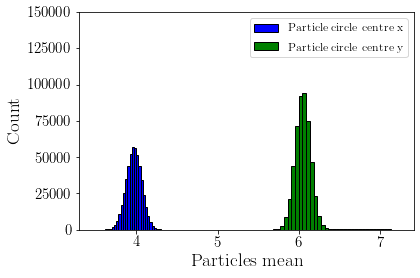

In [95]:
fig, ax = plt.subplots(1,1)
plt.hist(x_list, color = 'blue', edgecolor = 'black',
         bins = int(180/5), label = 'Particle circle centre x')
plt.hist(y_list, color = 'green', edgecolor = 'black',
         bins = int(180/5), label = 'Particle circle centre y')
plt.ylim((0,150000))
plt.ylabel('Count')
plt.xlabel('Particles mean')
plt.legend(fontsize = 12)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/hist1025052501000n5xy.png', format = 'png', dpi=400, bbox_inches='tight')

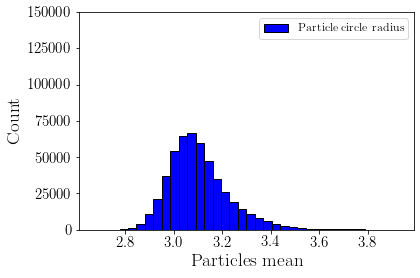

In [96]:
fig, ax = plt.subplots(1,1)
plt.hist(radius_list, color = 'blue', edgecolor = 'black',
         bins = int(180/5), label = 'Particle circle radius')
plt.ylim((0,150000))
plt.ylabel('Count')
plt.xlabel('Particles mean')
plt.legend(fontsize = 12)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/hist1025052501000n5r.png', format = 'png', dpi=400, bbox_inches='tight')

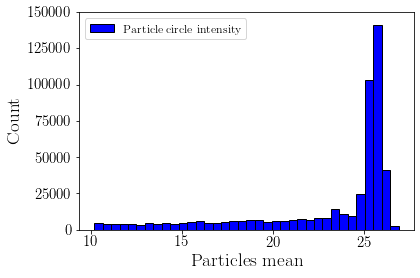

In [97]:
fig, ax = plt.subplots(1,1)
plt.hist(intensity_list, color = 'blue', edgecolor = 'black',
         bins = int(180/5), label = 'Particle circle intensity')
plt.ylim((0,150000))
plt.ylabel('Count')
plt.xlabel('Particles mean')
plt.legend(fontsize = 12)
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/hist1025052501000n5i.png', format = 'png', dpi=400, bbox_inches='tight')

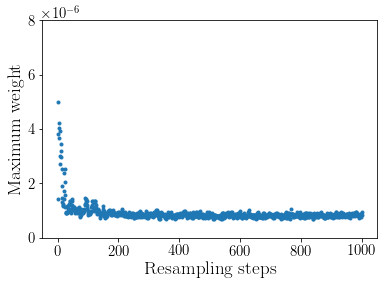

In [32]:
fig, ax = plt.subplots(1,1)
plt.plot([np.var(w) for w in weights], '.')
plt.ylim(0.00,0.8*10**-5)
plt.ylabel('Maximum weight')
plt.xlabel('Resampling steps')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/weightsvar1010055001000n0_5.png', format = 'png', dpi=400, bbox_inches='tight')

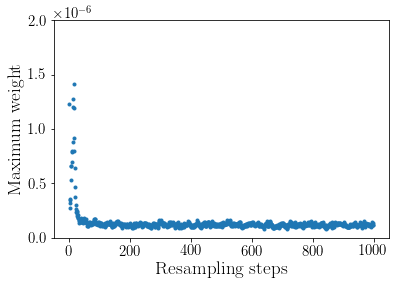

In [51]:
fig, ax = plt.subplots(1,1)
plt.plot([np.var(w) for w in weights], '.')
plt.ylim(0.00,0.2*10**-5)
plt.ylabel('Maximum weight')
plt.xlabel('Resampling steps')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/smc/weightsvar1010055001000n20.png', format = 'png', dpi=400, bbox_inches='tight')